In [1]:
%matplotlib inline
import gym
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from IPython.display import display
from JSAnimation.IPython_display import display_animation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import animation
from scipy import stats

Using TensorFlow backend.


In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [84]:
class LearningParameters:
    def __init__(self, state_size, action_size, episodes_count):
        self.state_size = state_size
        self.action_size = action_size
        self.episodes_count = episodes_count
        self.max_memory_size = 10000
        self.episodes_between_think = 5
        
        self.gamma = 0.95                # discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model (Adam optimizer)

    def decay_exploration_rate(self, episode):
        # Linear exploration rate decay (lerp)
#         self.epsilon = self.epsilon_start - \
#                       (self.epsilon_start - self.epsilon_min) * (float(frame) / self.frames_count)
            
        # Exponential rate decay
        # y(0) = start
        # y(1) = start * x
        # y(2) = start * x^2
        # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
        # y(t) = start * x^t
        self.epsilon = self.epsilon_start * \
                       math.pow( math.pow(self.epsilon_min / self.epsilon_start, 1.0 / self.episodes_count), episode )

In [60]:
def train_reward_is_discounted_predicted(env, agent, params):
    rewards = []
    
    all_replays = []
    
    for episode in range(params.episodes_count):
        state = np.reshape(env.reset(), [1, params.state_size])        
        frame = 0
        
        replays = []
        
        while True:
            action = agent.act(state)
            next_state, _, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, params.state_size])
    
            if done:
                break

            replays.append((state, action, next_state))
            frame += 1
            state = next_state
            
        all_replays.append(replays)
            
        rewards.append(len(replays))
            
        if (episode + 1) % (params.episodes_count / 20) == 0:
            print("episode: {}/{}, reward {}, exploration rate: {:.2}"
              .format(episode + 1, params.episodes_count, np.mean(rewards[-10:]), params.epsilon))
            
        if (episode + 1) % params.episodes_between_think == 0:
            agent.memory.clear()
            for replays in all_replays:
                reward_value = 0
                for index in reversed(range(len(replays))):
                    state, action, next_state = replays[index]
                    reward_value = reward_value * params.gamma + agent.model.predict(state)[0][action]
                    agent.remember(state, action, reward_value, next_state)
            agent.think(32)
        
        params.decay_exploration_rate(episode)

    return agent, rewards

## Action is added to input as OHE

In [107]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(20, input_dim=self.params.state_size + self.params.action_size, activation='relu'))
#         model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.params.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        X = np.resize(state[0], (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = self.model.predict(X)[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)

    def think(self, batch_size):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            state = np.resize(state[0], (self.params.state_size + self.params.action_size))
            state[self.params.state_size:] = 0
            state[self.params.state_size + action] = 1
            X[i], Y[i] = state, reward
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

## Policy Gradient
* Doesn't work with if predict immediate reward (method `train`)

In [81]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()
        
        X = np.random.uniform(-1.0, 1.0, (5000, self.params.state_size))
        Y = np.random.uniform(-0.0001, 0.0001, (5000, self.params.action_size))
        self.model.fit(X, Y, epochs=1, verbose=0)

    def _build_model(self):
        model = Sequential()
        model.add(Dense(20, input_dim=self.params.state_size, activation='relu'))
#         model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(self.params.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.params.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        act_values = self.model.predict(state)[0]
        return np.argmax(act_values)

    def think(self, batch_size):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = self.model.predict(state)[0]
            target[action] = reward
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [5]:
class DQNAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.params.state_size, activation='relu'))
#         model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(self.params.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.params.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def think(self, batch_size):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = self.model.predict(state)[0]
            target[action] = reward + self.params.gamma * \
                            np.amax(self.model.predict(next_state)[0])
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)

In [110]:
def train_reward_is_time(env, agent, params):
    """Ignore reward from the env, agent will be trained to increase total time played"""
    rewards = []
    
    all_replays = []
    
    for episode in range(params.episodes_count):
        state = np.reshape(env.reset(), [1, params.state_size])        
        frame = 0
        
        states = []
        replays = []
        
        while True:
            action = agent.act(state)
            next_state, _, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, params.state_size])
    
            if done:
                break

            states.append(state[0])
            replays.append((state, action, next_state))
            frame += 1
            state = next_state
        
#         states = np.array(states)
#         predicted = agent.model.predict(states)
#         reward_value = 0.0
#         for index in reversed(range(len(replays))):
#             state, action, next_state = replays[index]
#             reward_value = reward_value * params.gamma + predicted[index, action]
#             agent.remember(state, action, reward_value, next_state)
        
        for index, replay in enumerate(replays):
            state, action, next_state = replay
            reward_value = len(replays) - index
            agent.remember(state, action, reward_value, next_state)
            
        rewards.append(len(replays))
            
        if (episode + 1) % (params.episodes_count / 20) == 0:
            print("episode: {}/{}, reward {}, exploration rate: {:.2}"
              .format(episode + 1, params.episodes_count, np.mean(rewards[-10:]), params.epsilon))
            
        if (episode + 1) % params.episodes_between_think == 0:
            agent.think(32)
        
        params.decay_exploration_rate(episode)

    return agent, rewards

In [7]:
def train(env, agent, params):   
    rewards = []
    
    for episode in range(params.episodes_count):
        state = np.reshape(env.reset(), [1, params.state_size])        
        frame = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, params.state_size])
    
            if done:
                reward = -10
    
            if frame < env.spec.max_episode_steps:
                agent.remember(state, action, reward, next_state)
                
            frame += 1
            state = next_state
            
            if done:
                break
        
        rewards.append(frame)
            
        if (episode + 1) % (params.episodes_count / 20) == 0:
            print("episode: {}/{}, reward {}, exploration rate: {:.2}"
              .format(episode + 1, params.episodes_count, np.mean(rewards[-10:]), params.epsilon))
            
        if (episode + 1) % params.episodes_between_think == 0:
            agent.think(32)
        
        params.decay_exploration_rate(episode)

    return agent, rewards

In [8]:
def evaluate(env, agent, params, render, frames):
    state = env.reset()
    render_frames = []
    for e in range(frames):
        if render:
            render_frames.append(env.render(mode = 'rgb_array'))
        state = np.reshape(state, [1, params.state_size])
        action = agent.act_greedy(state)
        state, reward, done, _ = env.step(action)
        if done or e == frames - 1:
            print("score: {}"
                  .format(e))
            break

    if render:
        env.render(close=True)
        display_frames_as_gif(render_frames)

In [ ]:
# env.render(close=True)
print(env.spec.max_episode_steps)

In [9]:
env = gym.make('CartPole-v1')

[2017-06-18 12:34:34,069] Making new env: CartPole-v1


episode: 5/100, reward 28.8, exploration rate: 0.76
episode: 10/100, reward 27.6, exploration rate: 0.48
episode: 15/100, reward 21.8, exploration rate: 0.3
episode: 20/100, reward 14.0, exploration rate: 0.19
episode: 25/100, reward 9.7, exploration rate: 0.12
episode: 30/100, reward 9.0, exploration rate: 0.076
episode: 35/100, reward 9.9, exploration rate: 0.048
episode: 40/100, reward 9.9, exploration rate: 0.03
episode: 45/100, reward 9.0, exploration rate: 0.019
episode: 50/100, reward 110.3, exploration rate: 0.012
episode: 55/100, reward 125.0, exploration rate: 0.0076
episode: 60/100, reward 49.2, exploration rate: 0.0048
episode: 65/100, reward 58.5, exploration rate: 0.003
episode: 70/100, reward 196.4, exploration rate: 0.0019
episode: 75/100, reward 375.8, exploration rate: 0.0012
episode: 80/100, reward 448.7, exploration rate: 0.00076
episode: 85/100, reward 468.9, exploration rate: 0.00048
episode: 90/100, reward 428.8, exploration rate: 0.0003
episode: 95/100, reward 3

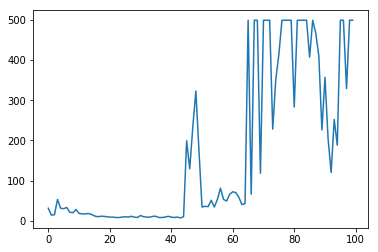

In [111]:
params = LearningParameters(env.observation_space.shape[0], env.action_space.n, 100)
# trained_agent, rewards = train_reward_is_time(env, PolicyGradientAgent(params), params)
# trained_agent, rewards = train(env, DQNAgent(params), params)
trained_agent, rewards = train_reward_is_time(env, ActionAsInputAgent(params), params)
plt.plot(rewards)

In [114]:
evaluate(env, trained_agent, params, False, 500)

score: 499
